Part 1 - Design and Build a CNN Classifier

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
from math import floor, ceil
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.optim import lr_scheduler


In [2]:
torch.manual_seed(0)

1. Display 5 images.
2. Use the CNN from tutorials 3-4 (CifarCnn()) and train it on the SVHN dataset (keep the architecture the same) for the same number of epochs with the same learning rate (try to keep the batch size the same, but if you get memory errors, you can reduce it). What is the accuracy on the test set? What classes are most confusing for this model?


Using downloaded and verified file: ./datasets\train_32x32.mat
Using downloaded and verified file: ./datasets\test_32x32.mat


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 256, 4, 4])
torch.Size([1, 4096])
num trainable weights:  5852170


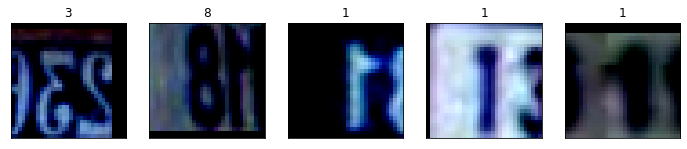

In [3]:
# define pre-processing steps on the images
# also called "data augementation" (only done for the train set)

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Normalize the test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


# load dataset
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
trainset = torchvision.datasets.SVHN(root='./datasets', split='train', transform=transform_train, download=True)
testset = torchvision.datasets.SVHN(root='./datasets', split='test', transform=transform_test, download=True)

# let's see some of the images
def convert_to_imshow_format(image):
    # first convert back to [0,1] range from [-1,1] range - approximately...
    image = image / 2 + 0.5
    image = image.numpy()
    # convert from CHW to HWC
    # from 3x32x32 to 32x32x3
    return image.transpose(1,2,0)
    
trainloader = torch.utils.data.DataLoader(trainset,
                                        batch_size=5,
                                        shuffle=True)
dataiter = iter(trainloader)
images, labels = dataiter.next()
fig, axes = plt.subplots(1, len(images), figsize=(12,2.5))
for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(classes[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

class SvhnCNN(nn.Module):
    """CNN for the CIFAR-10 Datset"""

    def __init__(self):
        """CNN Builder."""
        super(SvhnCNN, self).__init__()

        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )


        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 10)
        )


    def forward(self, x):
        """Perform forward."""
        
        # conv layers
        x = self.conv_layer(x)
        
        # flatten
        x = x.view(x.size(0), -1)
        
        # fc layer
        x = self.fc_layer(x)

        return x


# calculating the output size of the convolutional layers, before the FC layers
dummy_input = torch.zeros([1, 3, 32, 32])
dummy_model = SvhnCNN()
dummy_output = dummy_model.conv_layer(dummy_input)
print(dummy_output.shape)
dummy_output = dummy_output.view(dummy_output.size(0), -1)
print(dummy_output.shape)
# calculating the number of trainable weights
num_trainable_params = sum([p.numel() for p in dummy_model.parameters() if p.requires_grad])
print("num trainable weights: ", num_trainable_params)


# tutorial training from cifar 
# time to train our model
# hyper-parameters
batch_size = 128
learning_rate = 1e-4
epochs = 20

# dataloaders - creating batches and shuffling the data
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2)

# device - cpu or gpu?
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# loss criterion
criterion = nn.CrossEntropyLoss()

# build our model and send it to the device
model = SvhnCNN().to(device) # no need for parameters as we alredy defined them in the class

# optimizer - SGD, Adam, RMSProp...
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


# function to calcualte accuracy of the model
def calculate_accuracy(model, dataloader, device):
    model.eval() # put in evaluation mode
    total_correct = 0
    total_images = 0
    confusion_matrix = np.zeros([10,10], int)
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_images += labels.size(0)
            total_correct += (predicted == labels).sum().item()
            for i, l in enumerate(labels):
                confusion_matrix[l.item(), predicted[i].item()] += 1
    model_accuracy = total_correct / total_images * 100
    return model_accuracy, confusion_matrix

In [4]:
# training loop
for epoch in range(1, epochs + 1):
    model.train()  # put in training mode
    running_loss = 0.0
    epoch_time = time.time()
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        # send them to device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward + backward + optimize
        outputs = model(inputs)  # forward pass
        loss = criterion(outputs, labels)  # calculate the loss
        # always the same 3 steps
        optimizer.zero_grad()  # zero the parameter gradients
        loss.backward()  # backpropagation
        optimizer.step()  # update parameters

        # print statistics
        running_loss += loss.data.item()

    # Normalizing the loss by the total number of train batches
    running_loss /= len(trainloader)

    # Calculate training/test set accuracy of the existing model
    train_accuracy, _ = calculate_accuracy(model, trainloader, device)
    test_accuracy, _ = calculate_accuracy(model, testloader, device)

    log = "Epoch: {} | Loss: {:.4f} | Training accuracy: {:.3f}% | Test accuracy: {:.3f}% | ".format(epoch, running_loss, train_accuracy, test_accuracy)
    epoch_time = time.time() - epoch_time
    log += "Epoch Time: {:.2f} secs".format(epoch_time)
    print(log)
    
    # save model
    if epoch % 20 == 0:
        print('==> Saving model ...')
        state = {
            'net': model.state_dict(),
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoints'):
            os.mkdir('checkpoints')
        torch.save(state, './checkpoints/svhn_cnn_ckpt.pth')

print('==> Finished Training ...')

Epoch: 1 | Loss: 1.3071 | Training accuracy: 78.934% | Test accuracy: 79.429% | Epoch Time: 43.08 secs
Epoch: 2 | Loss: 0.5393 | Training accuracy: 86.871% | Test accuracy: 87.085% | Epoch Time: 43.10 secs
Epoch: 3 | Loss: 0.4046 | Training accuracy: 89.288% | Test accuracy: 89.348% | Epoch Time: 41.92 secs
Epoch: 4 | Loss: 0.3464 | Training accuracy: 90.734% | Test accuracy: 91.146% | Epoch Time: 42.36 secs
Epoch: 5 | Loss: 0.3116 | Training accuracy: 91.541% | Test accuracy: 91.910% | Epoch Time: 42.20 secs
Epoch: 6 | Loss: 0.2887 | Training accuracy: 92.337% | Test accuracy: 92.329% | Epoch Time: 41.21 secs
Epoch: 7 | Loss: 0.2694 | Training accuracy: 93.091% | Test accuracy: 92.782% | Epoch Time: 41.59 secs
Epoch: 8 | Loss: 0.2536 | Training accuracy: 93.531% | Test accuracy: 92.978% | Epoch Time: 42.11 secs
Epoch: 9 | Loss: 0.2424 | Training accuracy: 93.729% | Test accuracy: 93.539% | Epoch Time: 43.03 secs
Epoch: 10 | Loss: 0.2306 | Training accuracy: 94.115% | Test accuracy: 93

test accuracy: 94.614%


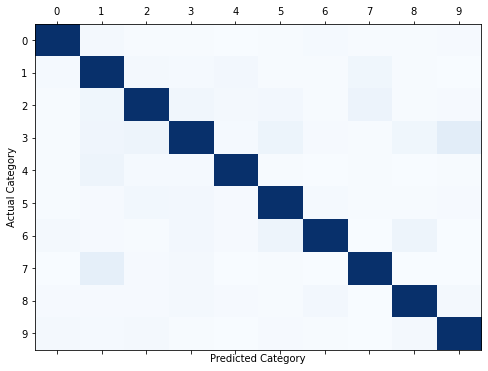

In [5]:
# load model, calculate accuracy and confusion matrix
model = SvhnCNN().to(device)
state = torch.load('./checkpoints/svhn_cnn_ckpt.pth', map_location=device)
model.load_state_dict(state['net'])

test_accuracy, confusion_matrix = calculate_accuracy(model, testloader, device)
print("test accuracy: {:.3f}%".format(test_accuracy))

# plot confusion matrix
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.show()

3. Design a Convolutional Neural Network (CNN) to classify digits from the images. You can modify the network from section 2, but you must get a better result than your baseline accuracy from section 2.

4. Train the classifier (preferably on a GPU - use Colab for this part if you don't have a GPU).

In [6]:
def find_svhn_mean_std():
    def find_mean_std(dataset):
        running_mean = 0
        running_std = 0
        for i in range(len(dataset)):
            image, _ = dataset[i]
            mean, std = image.view(3,-1).mean(1), image.view(3,-1).std(1)
            running_mean += mean.numpy()
            running_std += std.numpy()
        dataset_mean = running_mean / len(dataset)
        dataset_std = running_std / len(dataset)
        return dataset_mean, dataset_std

    traindata = torchvision.datasets.SVHN(root='./datasets', split='train', download=True, transform=transforms.ToTensor())
    testdata = torchvision.datasets.SVHN(root='./datasets', split='test', download=True, transform=transforms.ToTensor())
    #extradata = torchvision.datasets.SVHN(root='./datasets', split='extra', download=True, transform=transforms.ToTensor())
    trainmean, trainstd = find_mean_std(traindata)
    testmean, teststd = find_mean_std(testdata)
    #extramean, extrastd = find_mean_std(extradata)

    trainlen = len(traindata)
    testlen = len(testdata)
    #extralen = len(extradata)

    mean = (trainmean*trainlen + testmean*testlen) / (trainlen+testlen)
    std = (trainstd*trainlen + teststd*testlen) / (trainlen+testlen)
    print(mean, std)
find_svhn_mean_std()

Using downloaded and verified file: ./datasets\train_32x32.mat
Using downloaded and verified file: ./datasets\test_32x32.mat
[0.44154901 0.44605679 0.47180032] [0.12072468 0.12448521 0.10762194]


In [7]:
# pre-processing steps on the images
SVHN_mean = np.array((0.44154901, 0.44605679, 0.47180032))
SVHN_std = np.array((0.12072468, 0.12448521, 0.10762194))
transform_train = transforms.Compose([
    transforms.RandomRotation(degrees=10),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(SVHN_mean, SVHN_std),
])

# Normalize the test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(SVHN_mean, SVHN_std),
])


# load dataset
classes = ('0', '1', '2', '3', '4', 
           '5', '6', '7', '8', '9')

trainset = torchvision.datasets.SVHN(
    root='./datasets', split='train', download=True, transform=transform_train)

testset = torchvision.datasets.SVHN(
    root='./datasets', split='test', download=True, transform=transform_test)

trainset, valset = torch.utils.data.random_split(trainset, [ceil(len(trainset)*0.8), floor(len(trainset)*0.2)])

Using downloaded and verified file: ./datasets\train_32x32.mat
Using downloaded and verified file: ./datasets\test_32x32.mat


In [9]:
class BasicCNN(nn.Module):
    """Basic CNN"""

    def __init__(self, 
                 in_channels=3, image_size=(32,32), num_classes=10,
                 conv_fan1=32, conv_fan2=64, conv_fan3=128,
                 conv_fan4=128, conv_fan5=256, conv_fan6=256,
                 fc_fan1=1024, fc_fan2=512):
        """CNN Builder."""
        super(BasicCNN, self).__init__()

        if ((image_size[0] % 8) != 0) or ((image_size[1] % 8) != 0):
            print('input image dimensions must be a multiple of 8.')
            raise ValueError('dimension mismatch')
            
        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=in_channels, out_channels=conv_fan1, kernel_size=3, padding=1),
            nn.BatchNorm2d(conv_fan1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=conv_fan1, out_channels=conv_fan2, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=conv_fan2, out_channels=conv_fan3, kernel_size=3, padding=1),
            nn.BatchNorm2d(conv_fan3),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=conv_fan3, out_channels=conv_fan4, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=conv_fan4, out_channels=conv_fan5, kernel_size=3, padding=1),
            nn.BatchNorm2d(conv_fan5),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=conv_fan5, out_channels=conv_fan6, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )


        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear((image_size[0]//8) * (image_size[1]//8) * conv_fan6, 10),
            #nn.ReLU(inplace=True),
            #nn.Linear(fc_fan1, fc_fan2),
            #nn.ReLU(inplace=True),
            #nn.Dropout(p=0.1),
            #nn.Linear(fc_fan2, 10)
        )


    def forward(self, x):
        """Perform forward."""
        
        # conv layers
        x = self.conv_layer(x)
        
        # flatten
        x = x.view(x.size(0), -1)
        
        # fc layer
        x = self.fc_layer(x)

        return x

In [50]:
# calculating the output size of the convolutional layers, before the FC layers
dummy_input = torch.zeros([1, 3, 32, 32])
dummy_model = BasicCNN()
dummy_output = dummy_model.conv_layer(dummy_input)
print(dummy_output.shape)
dummy_output = dummy_output.view(dummy_output.size(0), -1)
print(dummy_output.shape)
# calculating the number of trainable weights
num_trainable_params = sum([p.numel() for p in dummy_model.parameters() if p.requires_grad])
print("num trainable weights: ", num_trainable_params)

torch.Size([1, 256, 4, 4])
torch.Size([1, 4096])
num trainable weights:  1167882


In [21]:
# hyper-parameters
batch_size = 64 #128
learning_rate = 4e-4 #1
epochs = 20
validation_acc_best = -np.Inf

# dataloaders - creating batches and shuffling the data
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(
    valset, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2)

# device - cpu or gpu?
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# loss criterion
criterion = nn.CrossEntropyLoss()

# build our model and send it to the device
model = BasicCNN().to(device) # no need for parameters as we alredy defined them in the class

# optimizer - SGD, Adam, RMSProp...
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
lr_sched = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.75)

In [22]:
# function to calcualte accuracy of the model
# TODO: delete
def calculate_accuracy(model, dataloader, device):
    model.eval() # put in evaluation mode
    total_correct = 0
    total_images = 0
    confusion_matrix = np.zeros([10,10], int)
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_images += labels.size(0)
            total_correct += (predicted == labels).sum().item()
            for i, l in enumerate(labels):
                confusion_matrix[l.item(), predicted[i].item()] += 1 

    model_accuracy = total_correct / total_images * 100
    return model_accuracy, confusion_matrix

In [23]:
# training loop
for epoch in range(1, epochs + 1):
    model.train()  # put in training mode
    running_loss = 0.0
    epoch_time = time.time()
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        # send them to device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward + backward + optimize
        outputs = model(inputs)  # forward pass
        loss = criterion(outputs, labels)  # calculate the loss
        # always the same 3 steps
        optimizer.zero_grad()  # zero the parameter gradients
        loss.backward()  # backpropagation
        optimizer.step()  # update parameters

        # print statistics
        running_loss += loss.data.item()

    # Normalizing the loss by the total number of train batches
    running_loss /= len(trainloader)

    # Calculate training/test set accuracy of the existing model
    train_accuracy, _ = calculate_accuracy(model, trainloader, device)
    validation_accuracy, _ = calculate_accuracy(model, valloader, device)
    test_accuracy, _ = calculate_accuracy(model, testloader, device)
    log = "Epoch: {} | Loss: {:.4f} | Training accuracy: {:.3f}% | Validation accuracy: {:.3f}% | Test accuracy: {:.3f}% ".format(epoch, running_loss, train_accuracy, validation_accuracy, test_accuracy)
    epoch_time = time.time() - epoch_time
    log += "Epoch Time: {:.2f} secs".format(epoch_time)
    print(log)
    
    lr_sched.step()
    # save model
    state = {
            'net': model.state_dict(),
            'epoch': epoch,
        }
    if not os.path.isdir('checkpoints'):
            os.mkdir('checkpoints')
    if validation_accuracy > validation_acc_best:
        validation_acc_best = validation_accuracy
        torch.save(state, './checkpoints/my_svhn_cnn_ckpt.pth')
        print(f'saving checkpooint, validation acc : {validation_accuracy} ')

print('==> Finished Training ...')

Epoch: 1 | Loss: 0.8685 | Training accuracy: 87.058% | Validation accuracy: 86.997% | Test accuracy: 89.482% Epoch Time: 43.84 secs
saving checkpooint, validation acc : 86.99747457511432 
Epoch: 2 | Loss: 0.3850 | Training accuracy: 90.622% | Validation accuracy: 90.205% | Test accuracy: 92.317% Epoch Time: 43.69 secs
saving checkpooint, validation acc : 90.20544672718586 
Epoch: 3 | Loss: 0.3176 | Training accuracy: 91.706% | Validation accuracy: 91.065% | Test accuracy: 92.959% Epoch Time: 43.97 secs
saving checkpooint, validation acc : 91.06545628284759 
Epoch: 4 | Loss: 0.2886 | Training accuracy: 92.514% | Validation accuracy: 91.748% | Test accuracy: 93.558% Epoch Time: 44.93 secs
saving checkpooint, validation acc : 91.74800354924578 
Epoch: 5 | Loss: 0.2526 | Training accuracy: 93.879% | Validation accuracy: 92.642% | Test accuracy: 94.342% Epoch Time: 43.56 secs
saving checkpooint, validation acc : 92.64214046822742 
Epoch: 6 | Loss: 0.2346 | Training accuracy: 94.210% | Valid

test accuracy: 95.863%


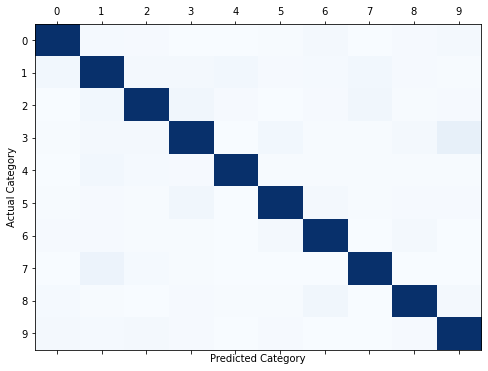

In [24]:
# load model, calculate accuracy and confusion matrix
model = BasicCNN().to(device)
state = torch.load('./checkpoints/my_svhn_cnn_ckpt.pth', map_location=device)
model.load_state_dict(state['net'])

test_accuracy, confusion_matrix = calculate_accuracy(model, testloader, device)
print("test accuracy: {:.3f}%".format(test_accuracy))

# plot confusion matrix
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.show()

Part 2 - Analyzing a Pre-trained CNN

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import cv2 
import json
from PIL import Image, ImageEnhance 

# pytorch
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

device = torch.device("cpu") # use cpu due to compatibility issues

1. Load a pre-trained VGG16 with PyTorch

In [28]:
# progress=True by default 
vgg16 = torchvision.models.vgg16(pretrained=True)
vgg16.to(device)
vgg16.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

2. Load the images in the ./birds folder and display them.

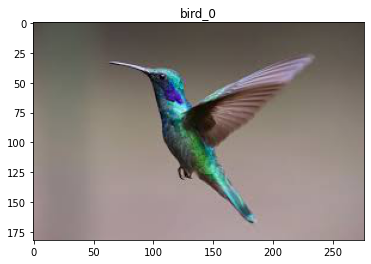

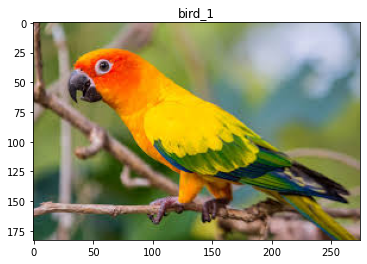

In [30]:
im1 = Image.open('./data/bird_0.jpg')
plt.imshow(im1)
plt.title('bird_0')
plt.show()

im2 = Image.open('./data/bird_1.jpg')
plt.imshow(im2)
plt.title('bird_1')
plt.show()

3. Pre-process the images to fit VGG16's architecture. What steps did you take?

In [31]:
# Data loading code
def norm(im):
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225])
        proc = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
        ])
        im = proc(im).unsqueeze(0)
        return im

4. Feed the images (forward pass) to the model. What are the outputs?

In [32]:
def predict(image, model, labels=None):
    _, index = model(image).data[0].max(0)
    if labels is not None:
        return str(index.item()), labels[str(index.item())][1]
    else:
        return str(index.item()) 

bird0_norm = norm(im1)
bird1_norm = norm(im2)

labels = json.load(open('./data/imagenet_class_index.json'))

print("im1 = ",predict(bird0_norm, vgg16.eval(), labels))
print("im2 = ",predict(bird1_norm, vgg16.eval(), labels))

im1 =  ('94', 'hummingbird')
im2 =  ('90', 'lorikeet')


5. Find an image of a bird/cat/dog on the internet, display it and feed it to network. What are the outputs?

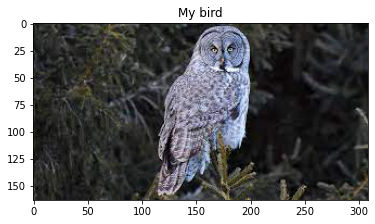

my bird =  ('24', 'great_grey_owl')


In [33]:
my_bird = Image.open('./data/ggowl.jpg')
plt.imshow(my_bird)
plt.title('My bird')
plt.show()

my_bird_norm = norm(my_bird)
plt.show()
print("my bird = ", predict(my_bird_norm, vgg16.eval(), labels))

6. Apply the following 3 transformations to create 3 *new* images from the image from step 5, and display them :
    * One **geometric transformation** (rotation, scaling, translation, warping...).
    * One **color transformation** (thresholding, different color space, hue, saturation, brightness, contrast...).
    * One **filter** (any filter you want).


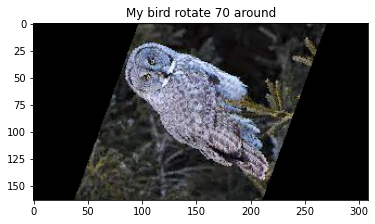

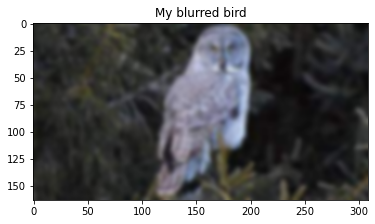

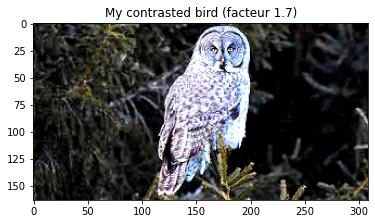

In [45]:
from PIL import ImageFilter
from PIL import ImageEnhance

my_bird_70deg = my_bird.rotate(70)
plt.imshow(my_bird_70deg)
plt.title('My bird rotate 70 around')
plt.show()
my_bird_70deg_norm = norm(my_bird_70deg)


my_bird_blur = my_bird.filter(ImageFilter.GaussianBlur(2))
plt.imshow(my_bird_blur)
plt.title('My blurred bird')
plt.show()
my_bird_blur_norm = norm(my_bird_blur)


enhancer = ImageEnhance.Contrast(my_bird)
factor = 1.7 
my_bird_contrasted = enhancer.enhance(factor)
plt.imshow(my_bird_contrasted)
plt.title('My contrasted bird (facteur 1.7)')
plt.show()
my_bird_contrasted_norm = norm(my_bird_contrasted)



7. Feed the transformed images to network, what is the output? is it different than section 5?

In [46]:
print("my_bird_70deg = ",predict(my_bird_70deg_norm, vgg16.eval(), labels))
print("my_bird_blur = ",predict(my_bird_blur_norm, vgg16.eval(), labels))
print("my_bird_contrasted = ",predict(my_bird_contrasted_norm, vgg16.eval(), labels))


my_bird_70deg =  ('43', 'frilled_lizard')
my_bird_blur =  ('210', 'German_short-haired_pointer')
my_bird_contrasted =  ('24', 'great_grey_owl')


8. For the first 3 filters in the *first layer* of VGG16, plot the filters, and then plot their response (their output) for the image from section 5 and the 3 images from section 6 (total of 4 input images). Explain what do you see.

torch.Size([3, 3, 3, 3])


E:\Anaconda\envs\deep_learn\lib\site-packages\ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


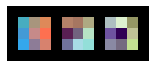

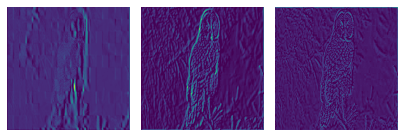

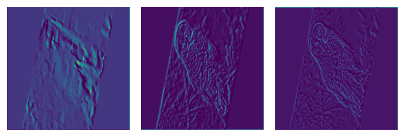

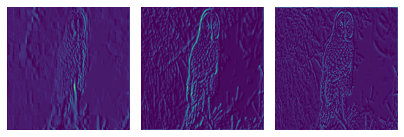

In [47]:
from torchvision import utils

def vistensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
    n, c, w, h = tensor.shape
    if allkernels: tensor = tensor.view(n*c, -1, w, h )
    elif c != 3: tensor = tensor[:, ch, :, :].unsqueeze(dim=1)     
    rows = np.min((tensor.shape[0] // nrow + 1, 64 ))    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure(figsize=(nrow,rows))
    plt.imshow(grid.cpu().numpy().transpose((1, 2, 0)))

def filter_outputs(image, model, layer_to_visualize):
    modulelist = list(model.features.modules())
    if layer_to_visualize < 0:
        layer_to_visualize += 31
    output = None
    name = None
    for count, layer in enumerate(modulelist[1:]):
        image = layer(image)
        if count == layer_to_visualize: 
            output = image
            name = str(layer) 
    filters = []
    output = output.data.squeeze().cpu().numpy()
    for i in range(output.shape[0]):
        filters.append(output[i,:,:])
    fig = plt.figure(figsize=(15, 15))
    for i in range(3):
        ax = fig.add_subplot(np.sqrt(len(filters)), np.sqrt(len(filters)), i+1)
        imgplot = ax.imshow(filters[i])
        ax.set_axis_off()
    plt.tight_layout()

kernel = vgg16.eval().features[0].weight.data.clone()
kernel = kernel[:3,:,:,:]
print(kernel.shape)
vistensor(kernel, ch=0, allkernels=False)
plt.axis('off')
filter_outputs(my_bird_norm, vgg16.eval(), 0)
filter_outputs(my_bird_70deg_norm, vgg16.eval(), 0)
filter_outputs(my_bird_contrasted_norm, vgg16.eval(), 0)
filter_outputs(my_bird_blur_norm, vgg16.eval(), 0)

9. For each image in the `./dogs` and `./cats` folders, extract and save their feature vectors (create a numpy array or a torch tensor that contains the features for all samples) from a fully-connected layer (such as `FC7`) of the VGG16 model. Which layer did you pick? What is the size of the feature space?
    

In [48]:
def my_save(image, model, layer_to_visualize):
    modulelist = list(model.features.modules())
    if layer_to_visualize < 0:
        layer_to_visualize += 31
    output = None
    name = None
    for count, layer in enumerate(modulelist[1:]):
        image = layer(image)
        if count == layer_to_visualize: 
            output = image
            name = str(layer)
    filters = []
    output = output.data.squeeze().cpu().numpy()
    for i in range(output.shape[0]):
        filters.append(output[i,:,:])   
    return filters

cats_filters = []
for i in range(10):
  cat_image = Image.open("./data/cats/cat_{}.jpg".format(i))
  cat_norm = norm(cat_image)
  filters = my_save(cat_norm, vgg16.eval(), 0)
  filters = np.reshape(filters,224*224*64)
  cats_filters.append(filters)

dogs_filters = []
for i in range(10):
  dog_image = Image.open("./data/dogs/dog_{}.jpg".format(i))
  dog_norm = norm(dog_image)
  filters = my_save(dog_norm, vgg16.eval(), 0)
  filters = np.reshape(filters,224*224*64)
  dogs_filters.append(filters)


10. Build a Support Vector Machine (SVM) classifier ( sklearn.svm.LinearSVC ) to classify cats and dogs based on the features you extracted. Use the 20 images as train set, and choose 4 images (2 dogs, 2 cats) from the internet as test sets. You can choose a different classifer than SVM from the scikit-learn library, no need to explain how it works (but report the name of the algorithm you used). What are the results?

In [49]:
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split


clf = LinearSVC()
clf.fit(np.concatenate((cats_filters,dogs_filters)), np.concatenate((np.ones(10),np.zeros(10))))
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(np.concatenate((cats_filters,dogs_filters)), np.concatenate((np.ones(10),np.zeros(10))))

my_cat_1 = Image.open("./data/newcat1.jpg")
plt.imshow(my_cat_1)
plt.show()
my_cat_1_norm = norm(my_cat_1)
my_cat_1_feature = my_save(my_cat_1_norm, vgg16.eval(), 0)
my_cat_1_feature = np.reshape(my_cat_1_feature,(1,224*224*64))
print("clf =", clf.predict(my_cat_1_feature))
print("neigh =", neigh.predict(my_cat_1_feature))

my_cat_2 = Image.open("./data/newcat2.jpg")
plt.imshow(my_cat_2)
plt.show()
my_cat_2_norm = norm(my_cat_2)
my_cat_2_feature = my_save(my_cat_2_norm, vgg16.eval(), 0)
my_cat_2_feature = np.reshape(my_cat_2_feature,(1,224*224*64))
print("clf =", clf.predict(my_cat_2_feature))
print("neigh =", neigh.predict(my_cat_2_feature))

my_dog_1 = Image.open("./data/newdog1.jpg")
plt.imshow(my_dog_1)
plt.show()
my_dog_1_norm = norm(my_dog_1)
my_dog_1_feature = my_save(my_dog_1_norm, vgg16.eval(), 0)
my_dog_1_feature = np.reshape(my_dog_1_feature,(1,224*224*64))
print("clf =", clf.predict(my_dog_1_feature))
print("neigh =", neigh.predict(my_dog_1_feature))

my_dog_2 = Image.open("./data/newdog2.jpg")
plt.imshow(my_dog_2)
plt.show()
my_dog_2_norm = norm(my_dog_2)
my_dog_2_feature = my_save(my_dog_2_norm, vgg16.eval(), 0)
my_dog_2_feature = np.reshape(my_dog_2_feature,(1,224*224*64))
print("clf =", clf.predict(my_dog_2_feature))
print("neigh =", neigh.predict(my_dog_2_feature))

clf = [1.]
neigh = [1.]


clf = [1.]
neigh = [1.]


clf = [0.]
neigh = [0.]


clf = [0.]
neigh = [0.]
